Este notebook está destinado al analisis de los valores de diferentes criptomonedas en el último tiempo

Lo primero será importar las librerias que usaremos para nuestro trabajo.

In [1]:
import datetime
import pandas as pd
import sklearn 
from sklearn.linear_model import LinearRegression
import numpy as np
import subprocess
import sys
import os
import psycopg2
from re import sub
import matplotlib.pyplot as plt
from random import sample

Lo siguiente será utilizar el script ya desarrollado para cargar los datos que queremos en la base de datos.

Para eso lo llamaremos utilizando Bash. Si queremos incorporar más monedas al analisis solo hay que agregarlas a la lista entre llaves ({'bitcoin','ethereum','cardano'}).

El delay de 60 segundos entre llamados al script es para no tener problemas con la API que tiene un límite de 50 llamados por minuto.

In [233]:
%%bash
for moneda in {'bitcoin','ethereum','cardano'}
do
    echo $moneda
    python3 obtenerValor.py $(date --date="-29 day" +%Y-%m-%d) $(date +%Y-%m-%d) $moneda postgres
    sleep 61
done

Process is terminated.


Ahora lo que haré es crear una serie de funciones que reciban una moneda y hagan el trabajo con dicha moneda. Esto para facilitar la escalabilidad en caso de querer estudiar otras monedas.

In [2]:
class Conexion:
    nombre = "postgres"
    usuario = "postgres"
    password = "mysecretpassword"
    host = "localhost"
    puerto = "5432"
    conexion = None
    cursor = None

    def __init__(self,_nombre = None, _usuario=None, _password=None, _host=None, _puerto = None) -> None:
        super().__init__()
        if _nombre != None:
            self.nombre = _nombre
        if _usuario != None:
            self.usuario = _usuario
        if _password != None:
            self.password = _password
        if _host != None:
            self.host = _host
        if _puerto != None:
            self.puerto = _puerto
        self.conexion = psycopg2.connect(
            dbname = self.nombre, user = self.usuario, 
            password = self.password, host = self.host,
            port = self.puerto)
        self.cursor = self.conexion.cursor()

    def cargarYGraficar(self,moneda):
        self.cursor.execute("SELECT coin_id,date,price from full_data where coin_id='{}'".format(moneda))
        datos = pd.DataFrame(self.cursor.fetchall())
        datos.columns = ['coin_id','date','price']
        
        datos['date'] = pd.to_datetime(datos['date'])
        datos['price'] = datos['price'].map(lambda x:float(sub(r'[^\d.]', '', x)))
        #datos['price'] =  pd.to_numeric(datos['price'])
        datos.plot('date','price',title=moneda, ylabel="USD")
        return datos
miConexion = Conexion()

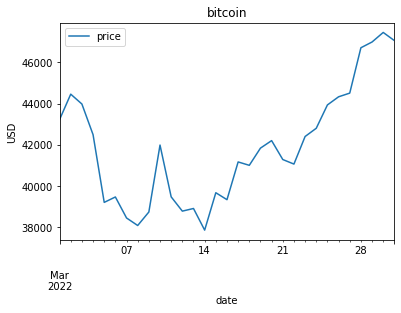

In [3]:
bitcoin = miConexion.cargarYGraficar('bitcoin')

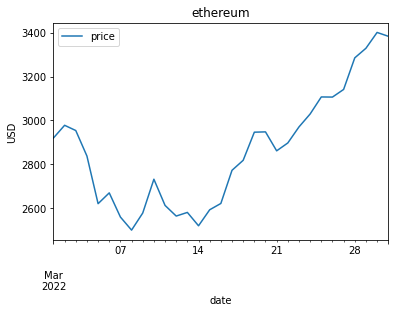

In [4]:
ethereum = miConexion.cargarYGraficar('ethereum')

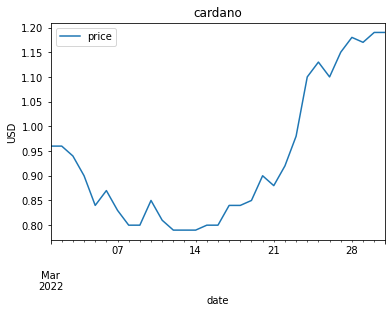

In [5]:
cardano = miConexion.cargarYGraficar('cardano')

Esta segunda clase tendrá las funciones relativas a la manipulación de los dataset. Es decir, primero a clasificar las monedas según su riesgo (Alto, Medio o Bajo), segundo generar los data sets con 7 días de lag, y tercero los aumentos de datos que querramos agregar, aunque si manipulamos datasets pequeños es recomendable no agregar demasiadas variables de este tipo para evitar el sobre ajuste a la hora de modelar los datos.

In [6]:
class Manipulador:
    def clasificar(datos):
        
        maxCaida = 1 - (np.array(datos['price'][1:])/
            np.array(datos['price'][:-1])).min()

        datos['High Risk'] = 0
        datos['Medium Risk'] = 0
        datos['Low Risk'] = 0
        if maxCaida >= 0.5:
            datos['High Risk'] = 1
        elif maxCaida >= 0.2:
            datos['Medium Risk'] = 1
        else:
            datos['Low Risk'] = 1
    def trendYvariance(datos):
    
        datos['trend'] = np.NAN
        datos['variance'] = np.NAN
        for i in range(7,len(datos['price'])):
            datos['trend'][i] = datos['price'][i]/(datos['price'][i-7:i].mean())
            datos['variance'][i] = (datos['price'][i-7:i].var())

    def obtenerLag(datos):
        datos2 = datos.copy()
        for i in range(1,8):
            datos2['lag-{}'.format(i)] = datos2['price'].shift(i)
        return datos2.dropna()


Vemos como al llamar a estas funciones agregamos las variables dummy.

In [7]:
Manipulador.clasificar(bitcoin)
Manipulador.clasificar(ethereum)
Manipulador.clasificar(cardano)
bitcoin.head(10)


,coin_id,date,price,High Risk,Medium Risk,Low Risk
0,bitcoin ...,2022-03-01,43225.40,0,0,1
1,bitcoin ...,2022-03-02,44459.59,0,0,1
2,bitcoin ...,2022-03-03,43980.71,0,0,1
3,bitcoin ...,2022-03-04,42491.98,0,0,1
4,bitcoin ...,2022-03-05,39200.30,0,0,1
5,bitcoin ...,2022-03-06,39463.15,0,0,1
6,bitcoin ...,2022-03-07,38442.99,0,0,1
7,bitcoin ...,2022-03-08,38076.49,0,0,1
8,bitcoin ...,2022-03-09,38732.94,0,0,1
9,bitcoin ...,2022-03-10,41986.03,0,0,1


Con estas agregamos columnas que nos dan la tendencia frente a la semana anterior (trend) y la varianza en la semana anterior (variance)

In [8]:
Manipulador.trendYvariance(bitcoin)
Manipulador.trendYvariance(ethereum)
Manipulador.trendYvariance(cardano)
bitcoin.head(10)

<ipython-input-6-7728d2796794>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['trend'][i] = datos['price'][i]/(datos['price'][i-7:i].mean())
<ipython-input-6-7728d2796794>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['variance'][i] = (datos['price'][i-7:i].var())
<ipython-input-6-7728d2796794>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['trend'][i] = datos['price'][i]/(datos['price'][i-7:i].mean())
<ipyt

,coin_id,date,price,High Risk,Medium Risk,Low Risk,trend,variance
0,bitcoin ...,2022-03-01,43225.40,0,0,1,NaN,NaN
1,bitcoin ...,2022-03-02,44459.59,0,0,1,NaN,NaN
2,bitcoin ...,2022-03-03,43980.71,0,0,1,NaN,NaN
3,bitcoin ...,2022-03-04,42491.98,0,0,1,NaN,NaN
4,bitcoin ...,2022-03-05,39200.30,0,0,1,NaN,NaN
5,bitcoin ...,2022-03-06,39463.15,0,0,1,NaN,NaN
6,bitcoin ...,2022-03-07,38442.99,0,0,1,NaN,NaN
7,bitcoin ...,2022-03-08,38076.49,0,0,1,0.915099,6.262234e+06
8,bitcoin ...,2022-03-09,38732.94,0,0,1,0.947627,7.275600e+06
9,bitcoin ...,2022-03-10,41986.03,0,0,1,1.048196,5.115298e+06


In [9]:
bitcoinLag = Manipulador.obtenerLag(bitcoin)
ethereumLag = Manipulador.obtenerLag(ethereum)
cardanoLag = Manipulador.obtenerLag(cardano)


In [10]:
class Modelo:
    modelo = None
    def __init__(self,datos):
        #print(datos)
        n = len(datos)
        index = sample(list(range(n)),int(n*0.8))
        features = datos.drop(['coin_id','price','date'], axis=1)
        label = datos['price']
        self.modelo = sklearn.linear_model.LinearRegression()
        self.modelo.fit(features,label)
        pred = self.modelo.predict(features)
        plt.scatter(label,pred)
        plt.title("Score = {}".format(self.modelo.score(features,label)))
        plt.show()
        

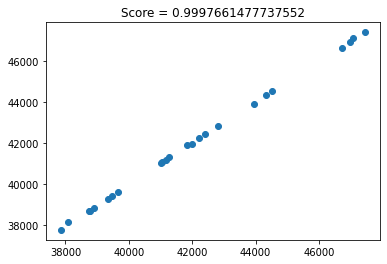

In [11]:
bitcoinModelo = Modelo(bitcoinLag)